### Clone GitHub repository

In [456]:
!git clone https://github.com/vagmarting/TM10007_Group_8.git

fatal: destination path 'TM10007_Group_8' already exists and is not an empty directory.


### Import

In [457]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import shapiro



### Load data

In [476]:
def load_data():
    data = pd.read_csv(os.path.join('hn','HN_radiomicFeatures.csv'), index_col=0)
    label = data["label"]
    label = label.replace(to_replace={'T12': False, 'T34': True}, value=None)
    data = data.drop(["label"], axis=1)
    return data, label

data, label = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(f'The dataset has {np.count_nonzero(label == 0)} samples with stage T12')
print(f'The dataset has {np.count_nonzero(label)} samples with stage T34')

The number of samples: 113
The number of columns: 159
The dataset has 58 samples with stage T12
The dataset has 55 samples with stage T34


### Check for missing data

In [459]:
# Detect missing values in dataframe
data.isnull().values.any()

False

### Data split

In [460]:
def split_data(data, label):
    train_data, test_data, train_label, test_label = train_test_split(data, label, train_size=0.7, stratify=label)
    return train_data, test_data, train_label, test_label

train_data, test_data, train_label, test_label = split_data(data, label)
print(f'The number of train samples: {train_data.shape[0]}')
print(f'The number of test samples: {test_data.shape[0]}')

The number of train samples: 79
The number of test samples: 34


### Preprocessing

In [461]:
def preprocessing(train_data, test_data):
    # Remove features with zero variance
    feature_names = train_data.columns.values
    selector = VarianceThreshold(threshold=0)
    selector.fit(train_data)
    zero_var_col = [column for column in train_data.columns if column not in train_data.columns[selector.get_support()]]
    train_data = selector.transform(train_data)
    test_data = selector.transform(test_data)
    feature_names_list = feature_names.tolist()
    feature_names_list = [i for i in feature_names if i not in zero_var_col]
    feature_names = np.array(feature_names_list)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    
    # Impute median value of feature for outliers
    train_values = train_data.values
    test_values = test_data.values

    for i in feature_names:
        median = train_data[i].median()
        upper_limit = train_data[i].quantile(0.99)
        lower_limit = train_data[i].quantile(0.01)
        train_values = train_data[i].values
        test_values = test_data[i].values
        for j in range(len(train_values)):
            if train_values[j] > upper_limit or train_values[j] < lower_limit:
                train_values[j] = median
        train_data[i] = train_values
        for k in range(len(test_values)):
            if test_values[k] > upper_limit or test_values[k] < lower_limit:
                test_values[k] = median
        test_data[i] = test_values

    # Scale features
    scaler = MinMaxScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    return train_data, test_data

### Normality check

In [462]:
non_normal = []
for i in range(len(train_data.values[0])):
    _, p = shapiro(train_data.values[:,i])
    if p < 0.05:
        non_normal.append(i)
print(f"There are {len(non_normal)} non-normally distributed features")

There are 131 non-normally distributed features


c:\Users\velde\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Select best features with Anova test

In [463]:
def select_features(kbest, train_data, train_label, test_data):
    feature_names = train_data.columns.values
    selector = VarianceThreshold(threshold=0)
    selector.fit(train_data)
    zero_var_col = [column for column in train_data.columns if column not in train_data.columns[selector.get_support()]]
    train_data = selector.transform(train_data)
    test_data = selector.transform(test_data)
    feature_names_list = feature_names.tolist()
    feature_names_list = [i for i in feature_names if i not in zero_var_col]
    feature_names = np.array(feature_names_list)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    
    fs = SelectKBest(score_func=f_classif, k=kbest)
    kbest_train = fs.fit_transform(train_data, train_label)
    kbest_test = fs.transform(test_data)
    return kbest_train, kbest_test

### Lasso Regression

In [464]:
def lasso_regression(train_data, train_label, test_data):
    sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
    sel_.fit(train_data, np.ravel(train_label,order='C'))
    sel_.get_support()
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    removed_feats = train_data.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    lasso_train = train_data.drop(removed_feats, axis='columns')
    lasso_test = test_data.drop(removed_feats, axis='columns')
    return lasso_train, lasso_test

### kNN Classifier


In [465]:
def knn_classifier(train_data, test_data, train_label):
    knn = KNeighborsClassifier()
    knn_neighbors = range(1,20)

    knn_param_grid = {
        'n_neighbors': knn_neighbors
    }

    knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=4)
    knn_grid_search.fit(train_data, train_label)
    
    best_knn_params = knn_grid_search.best_params_
    best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_params['n_neighbors'])
    best_knn_model.fit(train_data,train_label)
    knn_train = best_knn_model.predict(train_data)
    knn_test = best_knn_model.predict(test_data)
    return knn_train, knn_test, best_knn_model

### Random Forest Classifier

In [466]:
def random_forest(train_data, test_data, train_label):
    clf = RandomForestClassifier()
    n_estimators = range(20,140,15)
    max_depth = range(8, 15, 2)
    min_samples_leaf = range(2, 7)
    min_samples_split = range(3, 10, 2)

    rf_param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split
    }

    rf_random = RandomizedSearchCV(estimator=clf, param_distributions=rf_param_grid, n_iter=150, cv=4)
    rf_random.fit(train_data, train_label)
    
    best_rf_params = rf_random.best_params_
    best_rf_model = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], min_samples_split=best_rf_params['min_samples_split'],
                                    min_samples_leaf=best_rf_params['min_samples_leaf'], max_depth=best_rf_params['max_depth'])
    best_rf_model.fit(train_data,train_label)
    rf_random_train = best_rf_model.predict(train_data)
    rf_random_test = best_rf_model.predict(test_data)
    
    return rf_random_train, rf_random_test, best_rf_model

### Calculate outcome measures

In [467]:
def outcome_measures(results, label):
    score = metrics.accuracy_score(label, results)
    
    confusion_matrix = metrics.confusion_matrix(label, results)

    true_neg, false_pos, false_neg, true_pos = confusion_matrix.ravel()
    sens = true_pos/(true_pos + false_neg)
    spec = true_neg/(true_neg + false_pos)
    return score, sens, spec

### Find average accuracy over multiple classifications

In [468]:
loops = 30
num_best_features = 80
rf_score_train_array = np.zeros(loops)
rf_score_test_array = np.zeros(loops)
rf_sens_train = np.zeros(loops)
rf_spec_train = np.zeros(loops)
rf_sens_test = np.zeros(loops)
rf_spec_test = np.zeros(loops)
rf_roc_auc_train = np.zeros(loops)
rf_roc_auc_test = np.zeros(loops)
knn_score_train_array = np.zeros(loops)
knn_score_test_array = np.zeros(loops)
knn_sens_train = np.zeros(loops)
knn_spec_train = np.zeros(loops)
knn_sens_test = np.zeros(loops)
knn_spec_test = np.zeros(loops)
knn_roc_auc_train = np.zeros(loops)
knn_roc_auc_test = np.zeros(loops)

data, label = load_data()

for loop in range(loops):
    print(loop)
    train_data, test_data, train_label, test_label = split_data(data, label)
    train_data, test_data = preprocessing(train_data, test_data)

    # Find best features based on F-scores
    kbest_train, kbest_test = select_features(num_best_features, train_data, train_label, test_data)

    # Lasso regression
    lasso_train, lasso_test = lasso_regression(kbest_train, train_label, kbest_test)

    # Random forest classifier
    rf_train_results, rf_test_results, rf_best_model = random_forest(lasso_train, lasso_test, train_label)
    # kNN classifier
    knn_train_results, knn_test_results, knn_best_model = knn_classifier(lasso_train, lasso_test, train_label)

    # Calculate outcome measures for RF
    rf_score_train_array[loop], rf_sens_train[loop], rf_spec_train[loop] = outcome_measures(rf_train_results, train_label)
    rf_score_test_array[loop], rf_sens_test[loop], rf_spec_test[loop] = outcome_measures(rf_test_results, test_label)

    # Calculate outcome measures for kNN
    knn_score_train_array[loop], knn_sens_train[loop], knn_spec_train[loop] = outcome_measures(knn_train_results, train_label)
    knn_score_test_array[loop], knn_sens_test[loop], knn_spec_test[loop] = outcome_measures(knn_test_results, test_label)
 
    # Calculate AUC for RF
    yhat = rf_best_model.predict_proba(lasso_train)
    rf_train_pos_probs = yhat[:, 1]
    rf_roc_auc_train[loop] = roc_auc_score(train_label, rf_train_pos_probs)

    yhat = rf_best_model.predict_proba(lasso_test)
    rf_test_pos_probs = yhat[:, 1]
    rf_roc_auc_test[loop] = roc_auc_score(test_label, rf_test_pos_probs)

    # Calculate AUC for kNN
    yhat = knn_best_model.predict_proba(lasso_train)
    knn_train_pos_probs = yhat[:, 1]
    knn_roc_auc_train[loop] = roc_auc_score(train_label, knn_train_pos_probs)

    yhat = knn_best_model.predict_proba(lasso_test)
    knn_test_pos_probs = yhat[:, 1]
    knn_roc_auc_test[loop] = roc_auc_score(test_label, knn_test_pos_probs)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [469]:
# Calculate and print mean and std outcome values over all iterations
print(f"Mean train score RF: {np.mean(rf_score_train_array):.2f} (std = {np.std(rf_score_train_array):.2f})")
print(f"Mean test score RF: {np.mean(rf_score_test_array):.2f} (std = {np.std(rf_score_test_array):.2f})")
print(f"Mean train sens RF: {np.mean(rf_sens_train):.2f} (std = {np.std(rf_sens_train):.2f})")
print(f"Mean test sens RF: {np.mean(rf_sens_test):.2f} (std = {np.std(rf_sens_test):.2f})")
print(f"Mean train spec RF: {np.mean(rf_spec_train):.2f} (std = {np.std(rf_spec_train):.2f})")
print(f"Mean test spec RF: {np.mean(rf_spec_test):.2f} (std = {np.std(rf_spec_test):.2f})")
print(f"Mean train AUC RF: {np.mean(rf_roc_auc_train):.2f} (std = {np.std(rf_roc_auc_train):.2f})")
print(f"Mean test AUC RF: {np.mean(rf_roc_auc_test):.2f} (std = {np.std(rf_roc_auc_test):.2f})")
print("")
print(f"Mean train score kNN: {np.mean(knn_score_train_array):.2f} (std = {np.std(knn_score_train_array):.2f})")
print(f"Mean test score kNN: {np.mean(knn_score_test_array):.2f} (std = {np.std(knn_score_test_array):.2f})")
print(f"Mean train sens kNN: {np.mean(knn_sens_train):.2f} (std = {np.std(knn_sens_train):.2f})")
print(f"Mean test sens kNN: {np.mean(knn_sens_test):.2f} (std = {np.std(knn_sens_test):.2f})")
print(f"Mean train spec kNN: {np.mean(knn_spec_train):.2f} (std = {np.std(knn_spec_train):.2f})")
print(f"Mean test spec kNN: {np.mean(knn_spec_test):.2f} (std = {np.std(knn_spec_test):.2f})")
print(f"Mean train AUC kNN: {np.mean(knn_roc_auc_train):.2f} (std = {np.std(knn_roc_auc_train):.2f})")
print(f"Mean test AUC kNN: {np.mean(knn_roc_auc_test):.2f} (std = {np.std(knn_roc_auc_test):.2f})")

Mean train score RF: 0.93 (std = 0.04)
Mean test score RF: 0.71 (std = 0.06)
Mean train sens RF: 0.92 (std = 0.06)
Mean test sens RF: 0.69 (std = 0.09)
Mean train spec RF: 0.95 (std = 0.03)
Mean test spec RF: 0.74 (std = 0.12)
Mean train AUC RF: 0.98 (std = 0.01)
Mean test AUC RF: 0.80 (std = 0.06)

Mean train score kNN: 0.84 (std = 0.08)
Mean test score kNN: 0.66 (std = 0.08)
Mean train sens kNN: 0.80 (std = 0.12)
Mean test sens kNN: 0.62 (std = 0.13)
Mean train spec kNN: 0.87 (std = 0.10)
Mean test spec kNN: 0.71 (std = 0.15)
Mean train AUC kNN: 0.92 (std = 0.05)
Mean test AUC kNN: 0.71 (std = 0.10)


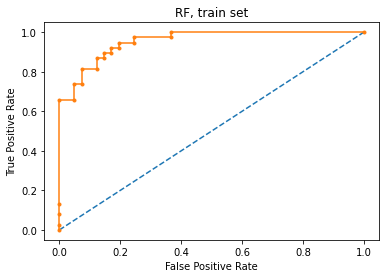

Area Under Curve = 0.95


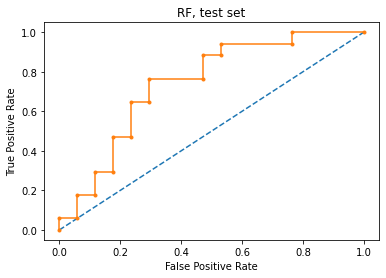

Area Under Curve = 0.74


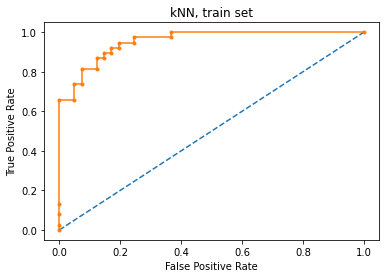

Area Under Curve = 0.95


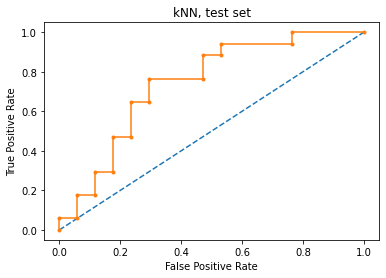

Area Under Curve = 0.74


'\n# ROC for kNN on train set\nyhat = knn_best_model.predict_proba(lasso_train)\npos_probs = yhat[:, 1]\nplt.plot([0, 1], [0, 1], linestyle=\'--\')\nfpr, tpr, _ = roc_curve(train_label, pos_probs)\nplt.plot(fpr, tpr, marker=\'.\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'ROC for the kNN classifier on the train set\')\nplt.show()\nroc_auc = roc_auc_score(train_label, pos_probs)\nprint(f"Area Under Curve = {roc_auc:.2f}")\n\n# ROC for kNN on test set\nyhat = knn_best_model.predict_proba(lasso_test)\npos_probs = yhat[:, 1]\nplt.plot([0, 1], [0, 1], linestyle=\'--\')\nfpr, tpr, _ = roc_curve(test_label, pos_probs)\nplt.plot(fpr, tpr, marker=\'.\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'ROC for the kNN classifier on the test set\')\nplt.show()\nroc_auc = roc_auc_score(test_label, pos_probs)\nprint(f"Area Under Curve = {roc_auc:.2f}")\n'

In [481]:
# ROC for RF on train set
for i in (rf_best_model, knn_best_model):
    yhat = rf_best_model.predict_proba(lasso_train)
    pos_probs = yhat[:, 1]
    plt.plot([0, 1], [0, 1], linestyle='--')
    fpr, tpr, _ = roc_curve(train_label, pos_probs)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{("RF" if i == rf_best_model else "kNN")}, train set')
    plt.show()
    roc_auc = roc_auc_score(train_label, pos_probs)
    print(f"Area Under Curve = {roc_auc:.2f}")

    # ROC for RF on test set
    yhat = rf_best_model.predict_proba(lasso_test)
    pos_probs = yhat[:, 1]
    plt.plot([0, 1], [0, 1], linestyle='--')
    fpr, tpr, _ = roc_curve(test_label, pos_probs)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{("RF" if i == rf_best_model else "kNN")}, test set')
    plt.show()
    roc_auc = roc_auc_score(test_label, pos_probs)
    print(f"Area Under Curve = {roc_auc:.2f}")



In [480]:
print(type(rf_best_model))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
